In [2]:
import tensorflow as tf

print(tf.__version__)


2.15.0


In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic #Holistic Model
mp_drawing = mp.solutions.drawing_utils #Drawing Utilities

In [5]:
def mediapipe_detection(image, model) :
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 #Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   # COLOR CONVERSION from RGB to BGR
    return image, results

In [6]:
def draw_landmarks(image, results) :
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results) :
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                             )
    # Draw hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                             )

In [8]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic :
    while cap.isOpened() :
        # Read feed
        ret, frame = cap.read()
    
        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        #Draw Landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q') :
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [9]:
len(results.right_hand_landmarks.landmark)

21

In [10]:
draw_landmarks(frame, results)

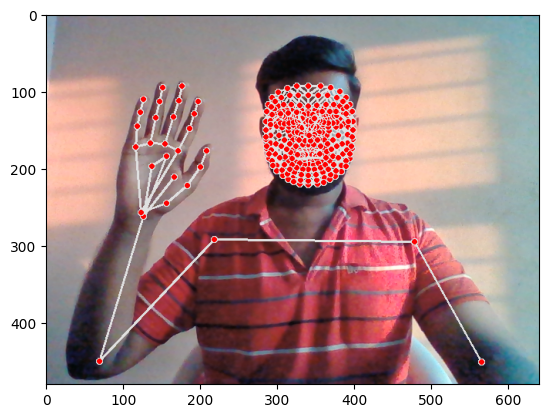

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [16]:
results.pose_landmarks.landmark[0]

x: 0.47121143341064453
y: 0.4358045756816864
z: -1.0686328411102295
visibility: 0.9977679252624512

In [10]:
def extract_keypoints(results) :
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [18]:
test_results = extract_keypoints(results) 
len(test_results)

1662

In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('NEW_DATASET')
# Actions that we try to detect 
actions = np.array(['GoodBye', 'Catch', 'Crown', 'Dance', 'Hello', 'None', 'Phone', 'Please', 'Thank-You', 'Yes'])
# Sixty videos worth of data
no_sequences = 30
# Videos are going to be 30 frames in length
sequence_length = 30

In [50]:
for action in actions :
    for sequence in range(no_sequences) :
        try :
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except :
            pass

In [51]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic :
    # Loop through actions
    for action in actions :
        # Loop through sequence aka videos
        for sequence in range(no_sequences) :
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length) :
                # Read feed
                ret, frame = cap.read()
            
                # Make Detections
                image, results = mediapipe_detection(frame, holistic)
                # print(results)
        
                #Draw Landmarks
                draw_styled_landmarks(image, results)

                # Apply wait logic
                if frame_num == 0 :
                    cv2.putText(image, 'STARTING COLLECTION', (120, 120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0 ,0 ,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else :
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q') :
                    break
                     
    cap.release()
    cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # used for one hot encoding

In [13]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'GoodBye': 0,
 'Catch': 1,
 'Crown': 2,
 'Dance': 3,
 'Hello': 4,
 'None': 5,
 'Phone': 6,
 'Please': 7,
 'Thank-You': 8,
 'Yes': 9}

In [14]:
sequences, labels = [], []
for action in actions :
    for sequence in range(no_sequences) :
        window = []
        for frame_num in range(sequence_length) :
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
np.array(sequences).shape

(300, 30, 1662)

In [16]:
np.array(labels).shape

(300,)

In [17]:
X = np.array(sequences)

In [18]:
Y = to_categorical(labels).astype(int)
Y.shape

(300, 10)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import TensorBoard

In [163]:
log_dir = './Logs/train'
# os.makedirs(log_dir, exist_ok=True)
tb_callback = TensorBoard(log_dir=log_dir)

In [165]:
%load_ext tensorboard
%tensorboard --logdir=Logs/train

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [125]:
model = Sequential([
    LSTM(64, return_sequences = True, activation ='relu', input_shape=(30, 1662)),
    Dropout(0.3),
    LSTM(128, return_sequences = True, activation ='relu'),
    Dropout(0.3),
    LSTM(64, return_sequences = False, activation ='relu'),
    Dropout(0.3),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(actions.shape[0], activation='softmax')
])

In [126]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [127]:
class myCallback(tf.keras.callbacks.Callback) :
    def on_epoch_end(self, epoch, logs={}) :
        accuracy = logs.get('categorical_accuracy')
        if(accuracy is not None and accuracy >= 0.95) :
            print("\n Reached 95% accuracy... So cancelling training!!!")
            self.model.stop_training = True
mycallback = myCallback()

In [128]:
model.fit(X_train, Y_train, epochs=250, callbacks=[mycallback, tb_callback])
# history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2, callbacks=[mycallback])

Epoch 1/250
9/9 [==============================] - 6s 165ms/step - loss: 2.6557 - categorical_accuracy: 0.1053
Epoch 2/250
9/9 [==============================] - 1s 142ms/step - loss: 2.2973 - categorical_accuracy: 0.1123
Epoch 3/250
9/9 [==============================] - 1s 117ms/step - loss: 2.2417 - categorical_accuracy: 0.1474
Epoch 4/250
9/9 [==============================] - 2s 221ms/step - loss: 2.2216 - categorical_accuracy: 0.2140
Epoch 5/250
9/9 [==============================] - 1s 145ms/step - loss: 2.2113 - categorical_accuracy: 0.1895
Epoch 6/250
9/9 [==============================] - 1s 156ms/step - loss: 2.0070 - categorical_accuracy: 0.2000
Epoch 7/250
9/9 [==============================] - 2s 204ms/step - loss: 1.8248 - categorical_accuracy: 0.2807
Epoch 8/250
9/9 [==============================] - 1s 151ms/step - loss: 1.7498 - categorical_accuracy: 0.3474
Epoch 9/250
9/9 [==============================] - 1s 141ms/step - loss: 1.5959 - categorical_accuracy: 0.3088
E

In [129]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 64)            442112    
                                                                 
 dropout_18 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_19 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [130]:
res = model.predict(X_test)

1/1 [==============================] - 1s 516ms/step


In [131]:
actions[np.argmax(res[8])]

'Hello'

In [132]:
actions[np.argmax(Y_test[8])]

'Hello'

In [134]:
model.save('final_model_10.h5')

e:\high-scale-projects\final_year_project\mediapipe-lstm_slr-model\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

In [136]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 62ms/step


In [137]:
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

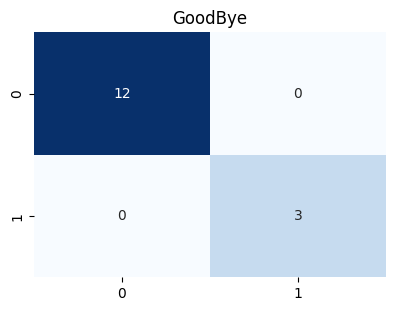

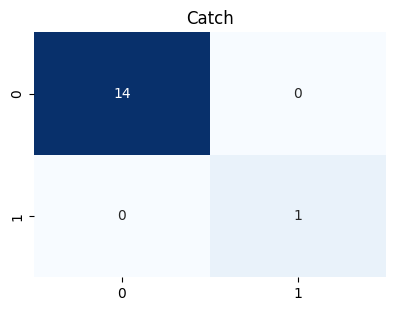

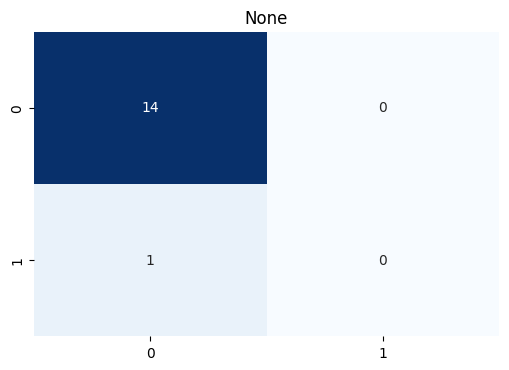

In [138]:
# Get the confusion matrix
conf_matrix = multilabel_confusion_matrix(ytrue, yhat)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix[1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'{actions[ytrue[1]]}')

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix[2], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'{actions[ytrue[2]]}')

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix[3], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'{actions[ytrue[3]]}')

plt.tight_layout()
plt.show()

In [139]:
accuracy_score(ytrue, yhat)

0.9333333333333333

In [98]:
# colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
# def prob_viz(res, actions, input_frame, colors) :
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res) :
#         cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#     return output_frame

In [99]:
# plt.imshow(prob_viz(res, actions, image, colors))

In [8]:
model = tf.keras.models.load_model(os.path.join('final_model_5-9579p.h5'))
# model = tf.keras.models.load_model(os.path.join('final_model_9-9614p.h5'))
print(model)

In [9]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        # draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0, keypoints)
        sequence = sequence[:30]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>


NameError: name 'extract_keypoints' is not defined

In [165]:
cap.release()
cv2.destroyAllWindows()